In [236]:
import numpy as np
import librosa
import librosa.display
import librosa.feature
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
import IPython.display as ipd
import glob
import os
import pandas as pd
import scipy
from scipy import stats
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import jams
import matplotlib.lines as mlines

<font size = 4> <b> Defining functions

In [2]:
def onset_clip(x, x_split, sr, pre = 0.1, post = 0.2):
    """
    Returns 0.3s onset_clip (0.1s before and 0.2s after the detected onset) after detecting onset based on librosa 
    and correlation between x and x_split
    """
    corr = scipy.signal.correlate(x, x_split, mode='full')
    corr_max = np.argmax(corr)-len(x_split)
    onset_frames = librosa.onset.onset_detect(x, sr=sr, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
    onset_times = librosa.frames_to_time(onset_frames, sr)
    onset_samples = onset_times * int(sr)
    onset_arg = np.argmin(np.abs(onset_samples-corr_max))
    onset_num = onset_samples[onset_arg]
    onset_clip = x[int(onset_num) - int(pre * sr): int(onset_num) + int(post * sr)]
    return onset_clip, onset_num

def wav_path_gen(files):
    """
    Generates path of corresponding wav_split_file
    Input: Subfolder of the form 'Dataset/wav/1/hamming_whole_step/filename.wav'
    """  
    wav_file = []
    for file in files:
        test = file.split('/')
        wav_name = test[4].split('.')[0].split('_')
        path = test[0] + '/wav/' + test[2] + '/' + test[3] + '/'
        wav_path = []
        for i in np.arange(len(wav_name)-1):   
            path = path + wav_name[i] +'_'
        wav_file.append(path[:-1] + '.wav')
    return wav_file

def wav_split_onset_num(files):
    path = []
    for file in files:
        path_test = file.split('/')[0] + '/wav_split/' + file.split('/')[2] + '/' + file.split('/')[3] + '/' + file.split('/')[4]
        path.append(path_test)
    return path

<font size = 4> <b> Onset Detection on dataset

In [3]:
# Tracking folder names
folders = os.listdir('Dataset/wav/1')
folders.remove('.DS_Store')
print (folders)

['hamming_whole_step', 'slide_whole_step_up', 'slide_whole_step_down', 'trill', 'normal_whole_step_up', 'bending_up_whole', 'mute', 'pulling_whole_step', 'bending_up_down_whole', 'hamming_half_step', 'slide_half_step_up', 'pulling_half_step', 'normal_half_step_down', 'slide_half_step_down', 'normal_half_step_up', 'normal', 'bending_up_down_half', 'bending_up_half', 'normal_whole_step_down']


<font size = 4> Reading all wav_split files from wav_split_v1 folder and finding corresponding wav files

In [4]:
files = glob.glob("Dataset/wav_split_final_v1/**/**/*.wav")
resample_rate = 44100

In [5]:
wav_files = wav_path_gen(files)
wav_split_files = wav_split_onset_num(files)

In [6]:
index = []
for fp in wav_split_files:
    index.append(fp)

In [7]:
wav_audio = []
for fp in wav_files:
    x, sr = librosa.load(fp, resample_rate)
    wav_audio.append(x)

In [8]:
wav_split_audio = []
for fp in wav_split_files:
    x, sr = librosa.load(fp, resample_rate)
    wav_split_audio.append(x)

In [9]:
# Creating a column for corresponding filenames
filenames = []
for i in range(0, len(files)):
    temp_file_name = index[i].split('/')
    name = temp_file_name[len(index[i].split('/'))-1]
    filenames.append(name)

audio_data = pd.DataFrame(filenames)
audio_data.columns = ['filename']

In [10]:
style = []
for i in np.arange(len(files)):
    test = audio_data.filename[i].split('_')
    test = test[0]
    style.append(test)

In [11]:
tone = []
for file in files:
    tone_file = file.split('/')[2]
    tone.append(tone_file)

In [12]:
# Detecting onsets using librosa and picking the ones closest to the wav split files
all_clips = []
all_onset_samples = []
for audio in np.arange(len(wav_audio)):
    x = wav_audio[audio]
    x_split = wav_split_audio[audio]
    clip, onset_sample = onset_clip(x, x_split, sr)
    all_clips.append(clip)
    all_onset_samples.append(onset_sample)

/Users/saksham/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/Users/saksham/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [13]:
onset = pd.DataFrame(np.array(all_onset_samples))
onset.columns = ['onset']
audio_data = pd.concat([audio_data, onset], axis = 1)

In [14]:
onset_nums = []
for name in filenames:
    onset_num = name.split('_')[-1].split('.')[0]
    onset_nums.append(onset_num)

In [15]:
onset_num = pd.DataFrame(onset_nums)
onset_num.columns = ['onset_num']
audio_data = pd.concat([audio_data, onset_num], axis = 1)

In [16]:
audio_data.head()

,filename,onset,onset_num
0,hamming_whole_step_19_1.wav,68608.0,1
1,hamming_whole_step_24_1.wav,67584.0,1
2,hamming_whole_step_8_1.wav,64000.0,1
3,hamming_whole_step_26_1.wav,68096.0,1
4,hamming_whole_step_22_1.wav,65536.0,1


<font size = 4> <b> Check Onset data quality

In [17]:
audio_data.describe()

,onset
count,3322.000000
mean,49840.472005
std,24162.172536
min,4096.000000
25%,22016.000000
50%,62464.000000
75%,65536.000000
max,173568.000000


In [18]:
len(all_clips[2])

13230

In [19]:
# Check clip length
all_clips_length = np.array([])
for clip_num in np.arange(audio_data['filename'].count()):
    length = len(all_clips[clip_num])
    all_clips_length = np.append(all_clips_length, length)

In [20]:
# np.argwhere(all_clips_length==0)
zeros = np.where(all_clips_length==0)[0]

In [21]:
clips = pd.DataFrame(audio_data, index = zeros)
clips.describe()

,onset
count,1.0
mean,4096.0
std,NaN
min,4096.0
25%,4096.0
50%,4096.0
75%,4096.0
max,4096.0


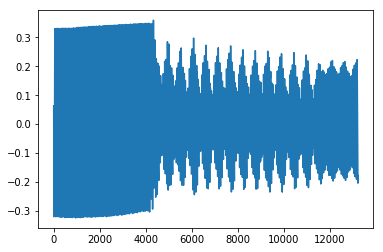

In [22]:
plt.plot(all_clips[3])

<font size = 4> <b> Computing Spectograms

In [789]:
# Parameters
n_fft = 2048
w = np.hamming(0.046 * sr)
# n_lift = 200
hop_length = int(0.01 * sr)

In [128]:
"""
Considering all clips with total length = 0.3s (Removing the shorter ones due to their positioning - 
either at extreme beginning or extreme end of the 4.0s file)
"""

all_clips_clean = []
filenames_clean = []
i = -1
for clip in all_clips:
    i = i+1
    if len(clip) == len(all_clips[0]):
        all_clips_clean.append(clip)
        temp_file_name = index[i].split('/')
        name = temp_file_name[len(index[i].split('/'))-1]
        filenames_clean.append(name)

all_clips_clean = np.array(all_clips_clean)
filenames_clean = np.array(filenames_clean)

In [129]:
all_clips_clean.shape

(3317, 13230)

In [130]:
# STFT for all samples
X = []
for clip in all_clips_clean:
    STFT = abs(librosa.stft(clip, n_fft=n_fft, hop_length=hop_length, window = 'hann'))
    X.append(STFT)
X = np.array(X)

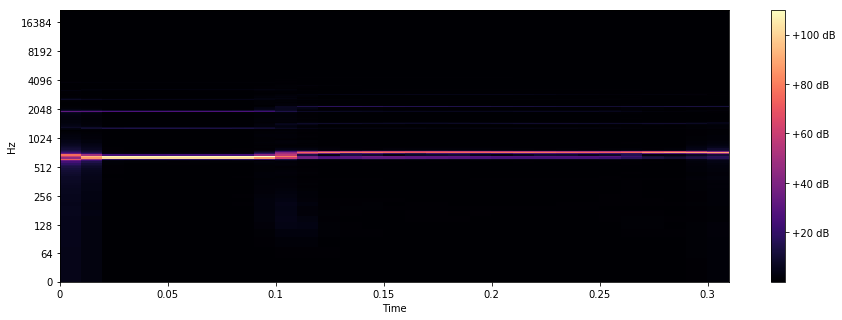

In [131]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(abs(X[3]), sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')

In [132]:
X.shape

(3317, 1025, 31)

In [133]:
filenames_clean.shape

(3317,)

In [134]:
style = []
for file in filenames_clean:
    style_file = file.split('_')[0]
    style.append(style_file)
Y = np.array(style)

In [135]:
# Changing Y to encoded values

from sklearn.preprocessing import LabelEncoder

sle = LabelEncoder()
style_labels = sle.fit_transform(Y)
style_mappings = {index: label for index, label in 
                  enumerate(sle.classes_)}
style_mappings
Y = style_labels

In [102]:
"""Using dataframe to store values"""

# # Defining a test_train_split function
# dataset = []
# for spect in np.arange(len(X)):
#     data_file = list(X[spect])
#     data_file.append(Y[spect])
#     dataset.append(data_file)

# dataset = np.array(dataset)

# df = pd.DataFrame(dataset)
# df = df.set_index(filenames_clean)

# column_names = np.arange(dataset.shape[1]-1)
# column_names = np.append(column_names, 'style')
# df.columns = column_names

# df['styleLabel'] = style_labels
# df = df.drop(['style'], axis = 1)
# df.head()

In [774]:
style_mappings

{0: 'bending',
 1: 'hamming',
 2: 'mute',
 3: 'normal',
 4: 'pulling',
 5: 'slide',
 6: 'trill'}

In [136]:
# # Defining a test_train_split function

print (X.shape)
print (Y.shape)

(3317, 1025, 31)
(3317,)


In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [159]:
X_train.shape

(2321, 1025, 31)

In [160]:
y_train.shape

(2321,)

<font size = 4> <b> Data Preparation

In [186]:
# specify input dimensions of each image
img_rows, img_cols = X_train.shape[1], X_train.shape[2]
input_shape = (img_rows, img_cols, 1)

# batch size, number of classes, epochs
batch_size = 128
num_classes = 7
epochs = 25

In [187]:
# reshape x_train and x_test
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
print(X_train.shape)
print(X_test.shape)

(2321, 1025, 31, 1)
(996, 1025, 31, 1)


In [188]:
# convert class labels (from digits) to one-hot encoded vectors
y_train_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_hot = keras.utils.to_categorical(y_test, num_classes)
print(y_train_hot.shape)
print(y_test_hot.shape)

(2321, 7)
(996, 7)


In [189]:
# originally, the pixels are stored as ints
X_train.dtype

dtype('float32')

In [190]:
X_train.shape

(2321, 1025, 31, 1)

<font size = 4> <b> Building the model

In [191]:
# model
model = Sequential()


model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 1024, 30, 32)      160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 512, 15, 32)       0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512, 15, 32)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 245760)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               31457408  
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 903       
Total para

<font size = 4> <b> Fitting and evaluating the model

In [192]:
# usual cross entropy loss
# choose any optimiser such as adam, rmsprop etc
# metric is accuracy
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [193]:
# fit the model
model.fit(X_train, y_train_hot,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test_hot))

Train on 2321 samples, validate on 996 samples
Epoch 1/25
2321/2321 [==============================] - 64s 28ms/step - loss: 7.3102 - acc: 0.2667 - val_loss: 1.6262 - val_acc: 0.3785
Epoch 2/25
2321/2321 [==============================] - 56s 24ms/step - loss: 1.4527 - acc: 0.4554 - val_loss: 1.3095 - val_acc: 0.5090
Epoch 3/25
2321/2321 [==============================] - 55s 24ms/step - loss: 1.1591 - acc: 0.5424 - val_loss: 1.4459 - val_acc: 0.5141
Epoch 4/25
2321/2321 [==============================] - 57s 25ms/step - loss: 0.9912 - acc: 0.6312 - val_loss: 1.1734 - val_acc: 0.5954
Epoch 5/25
2321/2321 [==============================] - 60s 26ms/step - loss: 0.8408 - acc: 0.6881 - val_loss: 1.3451 - val_acc: 0.5371
Epoch 6/25
2321/2321 [==============================] - 59s 25ms/step - loss: 0.7803 - acc: 0.7187 - val_loss: 0.9344 - val_acc: 0.7149
Epoch 7/25
2321/2321 [==============================] - 58s 25ms/step - loss: 0.6149 - acc: 0.7781 - val_loss: 0.9029 - val_acc: 0.7018
E

<font size = 4> <b> Model evaluation

In [194]:
# evaluate the model on test data
model.evaluate(X_test, y_test_hot)

996/996 [==============================] - 4s 4ms/step


[0.8738913540672286, 0.7690763052208835]

In [195]:
print(model.metrics_names)

['loss', 'acc']


In [204]:
# predict
y_pred = model.predict(X_test, batch_size = batch_size, verbose = 1)

996/996 [==============================] - 8s 8ms/step


In [205]:
y_rounded_pred = model.predict_classes(X_test, batch_size = batch_size, verbose = 1)

996/996 [==============================] - 4s 4ms/step


In [206]:
y_rounded_pred

array([0, 3, 4, 2, 6, 6, 5, 3, 3, 4, 1, 1, 4, 4, 5, 1, 4, 4, 4, 6, 4, 0,
       4, 1, 3, 4, 3, 2, 6, 0, 1, 4, 6, 0, 6, 0, 1, 0, 1, 5, 4, 1, 2, 1,
       1, 4, 4, 1, 5, 1, 6, 0, 2, 4, 1, 1, 5, 4, 0, 6, 6, 2, 2, 6, 4, 3,
       5, 0, 3, 3, 4, 3, 0, 1, 0, 5, 3, 1, 3, 3, 1, 3, 4, 4, 4, 1, 3, 4,
       0, 3, 4, 0, 1, 0, 0, 3, 4, 3, 6, 3, 3, 5, 5, 4, 4, 2, 2, 0, 1, 6,
       1, 0, 0, 2, 1, 3, 2, 4, 1, 3, 0, 6, 1, 4, 3, 5, 4, 1, 0, 1, 2, 3,
       3, 2, 4, 4, 6, 1, 4, 1, 6, 4, 3, 3, 3, 6, 1, 5, 2, 1, 3, 0, 0, 6,
       4, 1, 2, 4, 4, 2, 0, 4, 4, 4, 3, 0, 0, 4, 4, 5, 1, 4, 3, 1, 2, 3,
       3, 4, 5, 6, 1, 0, 1, 1, 1, 2, 1, 5, 6, 1, 4, 4, 4, 6, 0, 3, 5, 2,
       2, 1, 5, 1, 1, 2, 4, 1, 3, 3, 5, 1, 5, 1, 1, 4, 3, 6, 5, 4, 6, 0,
       5, 4, 3, 4, 1, 3, 2, 3, 2, 3, 2, 0, 3, 0, 3, 2, 3, 0, 3, 1, 0, 0,
       1, 1, 6, 2, 2, 1, 3, 1, 2, 1, 5, 1, 1, 5, 6, 4, 1, 0, 5, 2, 0, 5,
       1, 3, 2, 3, 6, 5, 5, 4, 1, 1, 2, 1, 0, 5, 5, 0, 1, 1, 3, 3, 3, 4,
       4, 2, 3, 3, 1, 6, 5, 2, 3, 3, 6, 5, 6, 4, 6,

In [207]:
# Evaluate the model using confusion matrix 
from sklearn import metrics
ConfusionMatrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_rounded_pred)

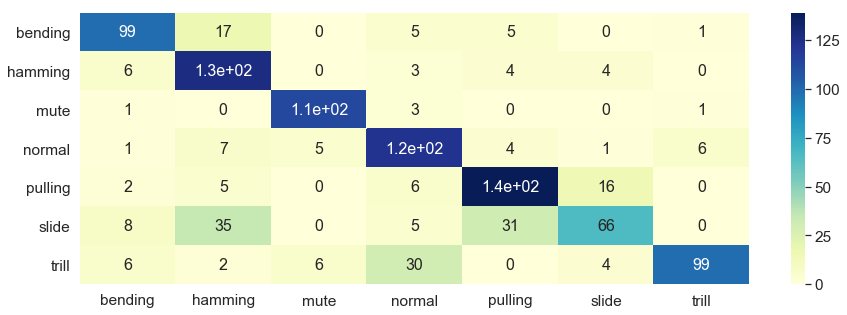

In [208]:
ConfusionMatrix = pd.DataFrame(ConfusionMatrix)
ConfusionMatrix = ConfusionMatrix.rename(index = style_mappings, columns = style_mappings)

plt.rcParams['figure.figsize']=[15,5]
sns.set(font_scale=1.4)
sns.heatmap(ConfusionMatrix, cmap="YlGnBu", annot=True, annot_kws={"size":16});

In [739]:
# print other metrics

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_rounded_pred))

# precision
print("precision", metrics.precision_score(y_test, y_rounded_pred, average = None))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_rounded_pred, average = None))

# F-Score
print ('F-Score', metrics.f1_score(y_test, y_rounded_pred, average = None))

print ('Avg F-score', np.mean(metrics.f1_score(y_test, y_rounded_pred, average = None)))

accuracy 0.7690763052208835
precision [0.80487805 0.65803109 0.91129032 0.70285714 0.75956284 0.72527473
 0.92523364]
recall [0.77952756 0.88194444 0.95762712 0.83673469 0.82738095 0.45517241
 0.67346939]
F-Score [0.792      0.7537092  0.9338843  0.76397516 0.79202279 0.55932203
 0.77952756]
Avg F-score 0.767777290941348


<font size = 4> <b> Reading onsets from NYU GuitarSet

In [270]:
def visualize_jams_onset_asList(jam, save_path=None, low=None, high=None, visualize=False):

    """ - Reading time location of all onsets detected in selected audio
    - Input parameters:
        1. jam: jams file to read annotations
    - Output: 2-D numpy array (onset time, string)
    """

    onsetList = []

    style_dict = {0 : 'r', 1 : 'y', 2 : 'b', 3 : '#FF7F50', 4 : 'g', 5 : '#800080'}
    string_dict = {0: 'E', 1: 'A', 2: 'D', 3: 'G', 4: 'B', 5: 'e' }
    s = 0
    handle_list = []
    if visualize:
        plt.figure(figsize=(16, 5))
    annos = jam.search(namespace='note_midi')
    if len(annos) == 0:
        annos = jam.search(namespace='pitch_midi')
    for string_tran in annos:
        handle_list.append(mlines.Line2D([], [], color=style_dict[s],label=string_dict[s]))
        for note in string_tran:

            start_time = note[0]

            if low and start_time < low:
                continue
            if high and start_time > high:
                continue

            onsetList.append([start_time, s])

            if visualize:
                plt.vlines(start_time,s, s+1,style_dict[s], label=string_dict[s])
        s += 1

    if visualize:
        plt.xlabel('sec')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), handles=handle_list)
        plt.ylabel('String Number')

    if not low:
        low = -0.1
    if not high:
        high = jam.file_metadata.duration

    if visualize:
        plt.xlim(low, high)
    # fig.set_size_inches(jam.file_metadata.duration / 2.5, 6)
    #    plt.title('Onsets of Individual Strings for excerpt of 00_Rock2-142-D_comp')
    if save_path:
        plt.savefig(save_path)


    onsetList.sort(key=lambda x: x[0])
    onsetList = np.array(onsetList)

    return onsetList

def onset_by_string(onsetList):
    """
    - Combining onsets by string in one list item
    - Input parameter: onsetList (output of visualize_jams_onset_asList)
    - Output: numpy array containing arrays by strings that further contain all onsets on that string

    """    
    onsetList = np.array(onsetList)
    onsetString = []
    for string in np.arange(6.):
        onsets = np.where(onsetList[:, 1] == string)
        onsets = onsetList[onsets, 0][0]
        onsetString.append(onsets)
    
    onsetString = np.array(onsetString)
    return onsetString

In [272]:
# Generate librosa onsets
def librosa_onsets(audio_hex, sr, onset_track):
    """
    Inputs: 
    - audio_hex: Audio file containing six channels
    - sr: SAMPLE RATE
    - onset_track: annotated onsets corresponding to audio_hex
    
    Returns: Matrix with n (number of onsets) tuple items. Within tuple, 0th element is the onset time and 
    1st element is the onset string for the closest onset detected by librosa with a maxerror (maximum distance
    between annotated onset and librosa onset) = 0.1

    """
    maxerror = 0.1
    librosa_onsets_detect = []
    librosa_onsets = []
    for string in np.arange(len(audio_hex)):
        onset_frames = librosa.onset.onset_detect(audio_hex[string], sr=SAMPLE_RATE, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
        onset_times = librosa.frames_to_time(onset_frames, sr = SAMPLE_RATE)
        for location in onset_track:
            if location[1] == string:
                onset_loc = np.argmin(np.abs(onset_times-location[0]))
                if np.abs(onset_times[onset_loc] - location[0]) < maxerror:
                    onset = np.append(onset_times[onset_loc], string)
                    librosa_onsets.append(onset)
    librosa_onsets = np.array(librosa_onsets)
    return librosa_onsets

In [773]:
def clip_from_onset(librosa_onsets_track, SAMPLE_RATE, audio, pre = 0.1, post = 0.2):
    """
    - Reading 0.3s data around detected onset. 
    - Audio has been clipped according to Taiwan Dataset (0.1s before the onset and 0.2s after the onset) in normal cases.
      Onset center has been adjusted in special cases to capture a 0.3s clip
    - Input parameters:
        1. onsetList (Onsets detected by Librosa)
        2. SAMPLE_RATE
        3. audio file
    - Output:
        1. array containing 0.3s time domain signal per onset
    """
    # 0.1s time frame before detected onset
    ta = int(pre * SAMPLE_RATE)
    # 0.2s time frame after detected onset
    tb = int(post * SAMPLE_RATE)
    all_clips = []

    string_init = -1

    for lib_onset_num in np.arange(len(librosa_onsets_track)):
        onset_sample = int(librosa_onsets_track[lib_onset_num][0] * SAMPLE_RATE)
#         pre_sample = int(librosa_onsets_track[lib_onset_num-1][0] * SAMPLE_RATE)
#         post_sample = int(librosa_onsets_track[lib_onset_num-1][0] * SAMPLE_RATE)
        string = int(librosa_onsets_track[lib_onset_num][1])
        
        if onset_sample >= ta and onset_sample <= len(audio[string]) - tb:
            x = audio[string][onset_sample-ta:onset_sample+tb]
        if onset_sample < ta:
            x = audio[string][:ta + tb]
        if onset_sample >len(audio[string]) - tb:
            x = audio[string][len(audio[string]) - ta-tb :]

#         if string > string_init:
#             if onset_sample >= ta:
#                 x = audio[string][onset_sample-ta:onset_sample+tb]
#             if onset_sample < ta:
#                 x = audio[string][: ta + tb]
            
#         if string == string_init:
#             if onset_sample - pre_sample >= ta and abs(post_sample - onset_sample) >= tb:
#                 x = audio[string][onset_sample-ta:onset_sample+tb]
#             if onset_sample - pre_sample < ta:
#                 x = audio[string][(pre_sample + onset_sample)//2: (pre_sample + onset_sample)//2 + ta + tb]
#             if post_sample - onset_sample < tb:
#                 x = audio[string][(post_sample + onset_sample)//2 - ta - tb: (post_sample + onset_sample)//2]
        if len(x) == ta + tb:
            all_clips.append(x)
#         string_init = string
    return all_clips

In [214]:
def solo_annotation_files(annotation_files):
    """Read just the solo annotation files from a folder (out of both, solo and comp annotations)"""
    solo_annotations = []
    for i in np.arange(len(annotation_files)):
        if annotation_files[i].split('_')[2][:4] == 'solo':
            solo_annotations.append(annotation_files[i]) 
    return solo_annotations

def audio_path_generator(solo_files, filetype = '_hex.wav', rectype = 'audio_hex-pickup_original'):
    """Generates paths of audio files to be read in the same order as annotation files"""
    audio_paths = []
    for path in solo_files:
        audio_name = path.split('/')[2][:-5] + filetype
        audio_path = path.split('/')[0] + '/audio/' + rectype + '/' + audio_name
        audio_paths.append(audio_path)
    return audio_paths

In [350]:
# Generating paths to read all types of files
annotation_paths = glob.glob("GuitarSet/annotation/*.jams")
solo_files_paths = solo_annotation_files(annotation_paths)
solo_audio_paths = audio_path_generator(solo_files_paths)
resample_rate = 44100

In [351]:
# Reading all audio files
all_audio_files = []
for path in solo_audio_paths:
    solo, SAMPLE_RATE = librosa.load(path, sr = resample_rate, mono = False)
    all_audio_files.append(solo)

In [749]:
"""
1. Reading annotated onsets
2. Picking the librosa onset closest to the annotated onsets
3. Clipping 0.3s audio segment around the onset
"""
all_clips_dataset = []
librosa_onsets_all = []
for file in np.arange(len(solo_files_paths)):
    annotation_track = jams.load(solo_files_paths[file])
    onset_track = visualize_jams_onset_asList(annotation_track, visualize = False)
    librosa_onsets_track = librosa_onsets(all_audio_files[file], SAMPLE_RATE, onset_track)
    librosa_onsets_all.append(librosa_onsets_track)
    all_clips = clip_from_onset(librosa_onsets_track, SAMPLE_RATE, all_audio_files[file])
    all_clips_dataset.append(all_clips)

In [750]:
values = np.array([])
for clip_one in all_clips_dataset:
    for test in clip_one:
        values = np.append(values, np.sum(np.abs(test)))
print (min(values))
print (min(values)/float(sr))
print (max(values))
print (max(values)/float(sr))
print (np.argmin(values))
print (len(values))
print (values)

13.77972412109375
0.00031246539957128686
3322.360595703125
0.07533697495925454
6921
15644
[262.96148682 245.00366211 486.31130981 ... 234.09594727 412.17663574
 418.85705566]


In [751]:
print (len(all_clips_dataset))
print (len(all_clips_dataset[0]))

tot_clips = 0
for i in all_clips_dataset:
    tot_clips += len(i)
tot_clips

178
73


15644

In [752]:
len_all_clips_dataset = np.array([])
for solo in all_clips_dataset:
    for clip in solo:
        len_all_clips_dataset = np.append(len_all_clips_dataset, len(clip))

<font size = 4> <b> Data preparation

In [753]:
X_NYU = []
for solo in all_clips_dataset:
    for clip in solo:
        STFT = abs(librosa.stft(clip, n_fft=n_fft, hop_length=hop_length, window = 'hann'))
        X_NYU.append(STFT)
X_NYU = np.array(X_NYU)

In [754]:
X_NYU.shape

(15644, 1025, 31)

In [755]:
X_NYU = X_NYU.reshape(X_NYU.shape[0], img_rows, img_cols, 1)
X_NYU.shape

(15644, 1025, 31, 1)

In [756]:
# predict
y_NYU_pred = model.predict(X_NYU, batch_size = batch_size, verbose = 1)
y_NYU_rounded_pred = model.predict_classes(X_NYU, batch_size = batch_size, verbose = 1)

15644/15644 [==============================] - 75s 5ms/step


In [775]:
len(y_NYU_rounded_pred)

15644

<font size = 4> <b> Analysis

In [758]:
# Rearranging y in the same order as all clips (dataset) for analysis
y_init = 0
y_all = []
for solo_num in np.arange(len(all_clips_dataset)):
    onsets_solo = []
    for onset_num in np.arange(len(all_clips_dataset[solo_num])):
        onsets_solo.append(y_NYU_rounded_pred[y_init])
        y_init += 1
    y_all.append(onsets_solo)

In [780]:
y_all = np.array(y_all)
print (y_all.shape)
print (len(y_all[0]))
print (len(y_all[1]))

(178,)
73
85


In [760]:
style_predictions = []
for solo in y_all:
    style_split = []
    for i in np.arange(7):
        style_split.append(solo.count(i))
    style_predictions.append(style_split)

style_predictions = np.array(style_predictions)

In [761]:
style_predictions.shape

(178, 7)

<font size = 4> Analysis file preparation

In [762]:
# Creating dataframe containing number of onsets, by playing style, by solo
analysis_df = pd.DataFrame(style_predictions)

# Renaming columns as per style
style_map = np.array([])
for style in style_mappings:
    style_map = np.append(style_map, style_mappings[style])    
analysis_df.columns = style_map

# Setting index as filename (annotation)
# Adding genre as a column
index_df = np.array([])
genres = np.array([])
for file in solo_files_paths:
    genre = file.split('/')[2].split('_')[1].split('-')[0][:-1]
    genres = np.append(genres, genre)
    index = file.split('/')[2]
    index_df = np.append(index_df, index)
    
analysis_df['Genre'] = genres
analysis_df = analysis_df.set_index(index_df)

In [763]:
# Total number of onsets, by Genre, by Style
Bending = analysis_df.groupby("Genre")["bending"].sum()
Hamming = analysis_df.groupby("Genre")["hamming"].sum()
Mute = analysis_df.groupby("Genre")["mute"].sum()
Normal = analysis_df.groupby("Genre")["normal"].sum()
Pulling = analysis_df.groupby("Genre")["pulling"].sum()
Slide = analysis_df.groupby("Genre")["slide"].sum()
Trill = analysis_df.groupby("Genre")["trill"].sum()

# Genre map corresponding to order in which above individual styles have stored data
genre_map = ['BN', 'Funk', 'Jazz', 'Rock', 'SS']
style_map_df = ['Bending', 'Hamming', 'Mute', 'Normal', 'Pulling', 'Slide', 'Trill']

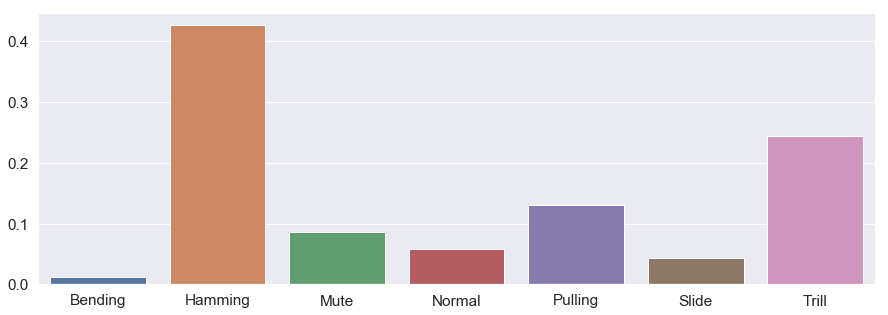

In [764]:
# Bossa Nova
genre = 0
total_onsets = Bending[genre] + Hamming[genre] + Mute[genre] + Normal[genre] + Pulling[genre] + Slide[genre] + Trill[genre]
bn_bend_prop = Bending[genre]/float(total_onsets)
bn_hamm_prop = Hamming[genre]/float(total_onsets)
bn_mute_prop = Mute[genre]/float(total_onsets)
bn_norm_prop = Normal[genre]/float(total_onsets)
bn_pull_prop = Pulling[genre]/float(total_onsets)
bn_slide_prop = Slide[genre]/float(total_onsets)
bn_trill_prop = Trill[genre]/float(total_onsets)

bn_prop_matrix = [bn_bend_prop, bn_hamm_prop, bn_mute_prop, bn_norm_prop, bn_pull_prop, bn_slide_prop, bn_trill_prop]

sns.barplot(x=style_map_df, y=bn_prop_matrix)


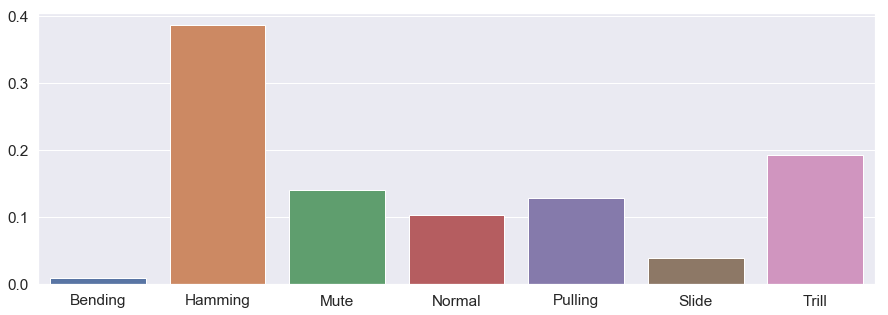

In [765]:
# Funk
genre = 1
total_onsets = Bending[genre] + Hamming[genre] + Mute[genre] + Normal[genre] + Pulling[genre] + Slide[genre] + Trill[genre]
funk_bend_prop = Bending[genre]/float(total_onsets)
funk_hamm_prop = Hamming[genre]/float(total_onsets)
funk_mute_prop = Mute[genre]/float(total_onsets)
funk_norm_prop = Normal[genre]/float(total_onsets)
funk_pull_prop = Pulling[genre]/float(total_onsets)
funk_slide_prop = Slide[genre]/float(total_onsets)
funk_trill_prop = Trill[genre]/float(total_onsets)

funk_prop_matrix = [funk_bend_prop, funk_hamm_prop, funk_mute_prop, funk_norm_prop, funk_pull_prop, funk_slide_prop, funk_trill_prop]
sns.barplot(x=style_map_df, y=funk_prop_matrix)

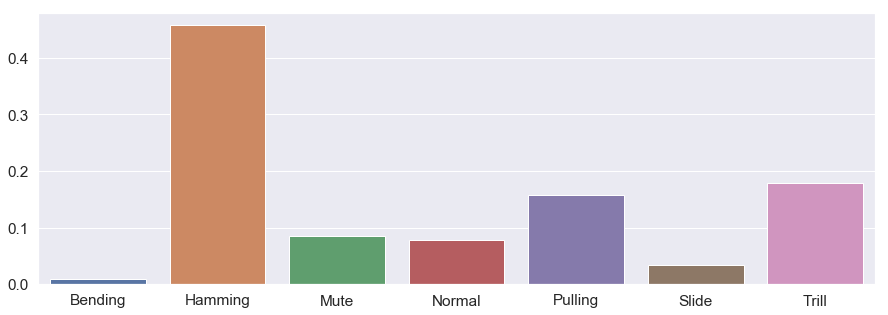

In [766]:
# Jazz
genre = 2
total_onsets = Bending[genre] + Hamming[genre] + Mute[genre] + Normal[genre] + Pulling[genre] + Slide[genre] + Trill[genre]
Jazz_bend_prop = Bending[genre]/float(total_onsets)
Jazz_hamm_prop = Hamming[genre]/float(total_onsets)
Jazz_mute_prop = Mute[genre]/float(total_onsets)
Jazz_norm_prop = Normal[genre]/float(total_onsets)
Jazz_pull_prop = Pulling[genre]/float(total_onsets)
Jazz_slide_prop = Slide[genre]/float(total_onsets)
Jazz_trill_prop = Trill[genre]/float(total_onsets)

Jazz_prop_matrix = [Jazz_bend_prop, Jazz_hamm_prop, Jazz_mute_prop, Jazz_norm_prop, Jazz_pull_prop, Jazz_slide_prop, Jazz_trill_prop]
sns.barplot(x=style_map_df, y=Jazz_prop_matrix)

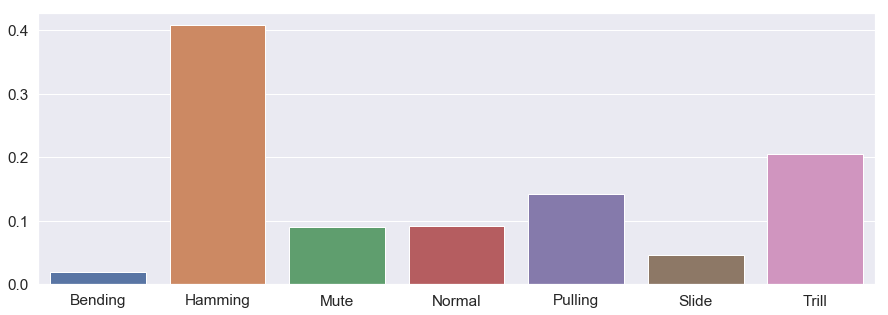

In [767]:
# Rock
genre = 3
total_onsets = Bending[genre] + Hamming[genre] + Mute[genre] + Normal[genre] + Pulling[genre] + Slide[genre] + Trill[genre]
rock_bend_prop = Bending[genre]/float(total_onsets)
rock_hamm_prop = Hamming[genre]/float(total_onsets)
rock_mute_prop = Mute[genre]/float(total_onsets)
rock_norm_prop = Normal[genre]/float(total_onsets)
rock_pull_prop = Pulling[genre]/float(total_onsets)
rock_slide_prop = Slide[genre]/float(total_onsets)
rock_trill_prop = Trill[genre]/float(total_onsets)

rock_prop_matrix = [rock_bend_prop, rock_hamm_prop, rock_mute_prop, rock_norm_prop, rock_pull_prop, rock_slide_prop, rock_trill_prop]
sns.barplot(x=style_map_df, y=rock_prop_matrix)

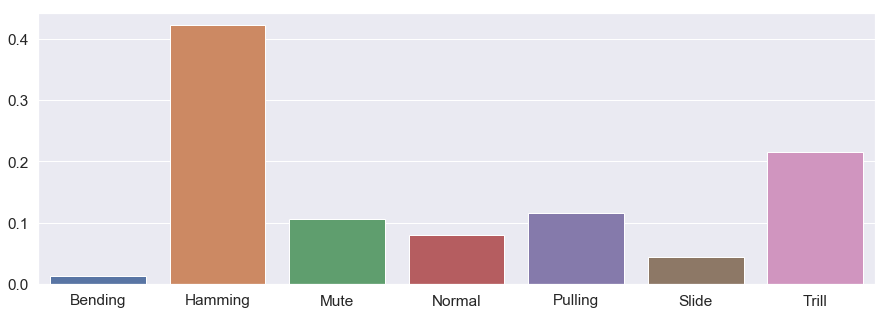

In [768]:
# SS
genre = 4
total_onsets = Bending[genre] + Hamming[genre] + Mute[genre] + Normal[genre] + Pulling[genre] + Slide[genre] + Trill[genre]
ss_bend_prop = Bending[genre]/float(total_onsets)
ss_hamm_prop = Hamming[genre]/float(total_onsets)
ss_mute_prop = Mute[genre]/float(total_onsets)
ss_norm_prop = Normal[genre]/float(total_onsets)
ss_pull_prop = Pulling[genre]/float(total_onsets)
ss_slide_prop = Slide[genre]/float(total_onsets)
ss_trill_prop = Trill[genre]/float(total_onsets)

ss_prop_matrix = [ss_bend_prop, ss_hamm_prop, ss_mute_prop, ss_norm_prop, ss_pull_prop, ss_slide_prop, ss_trill_prop]
sns.barplot(x=style_map_df, y=ss_prop_matrix)

In [769]:
style_by_genre_normalised = [bn_prop_matrix, funk_prop_matrix, Jazz_prop_matrix, rock_prop_matrix, ss_prop_matrix]

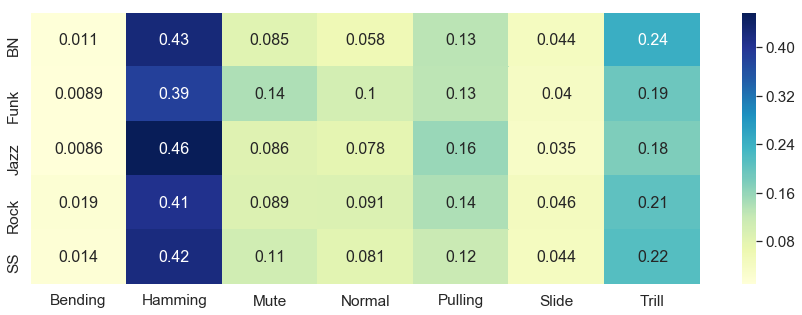

In [770]:
sns.heatmap(style_by_genre_normalised, cmap="YlGnBu", annot=True, annot_kws={"size":16}, xticklabels=style_map_df, yticklabels = genre_map);

2
[2.03174603 2.        ]


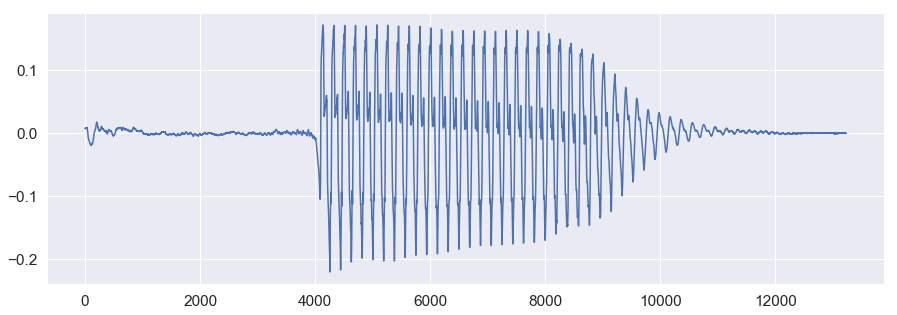

In [793]:
file = 0
onset_num = 2

print (y_all[file][onset_num])
print (librosa_onsets_all[file][onset_num])
plt.plot(all_clips_dataset[file][onset_num])
ipd.Audio(all_clips_dataset[file][onset_num], rate = sr)

In [710]:
X_NYU_STFT = X_NYU.reshape(X_NYU.shape[0], img_rows, img_cols)
X_NYU_STFT.shape

(15644, 1025, 31)

6


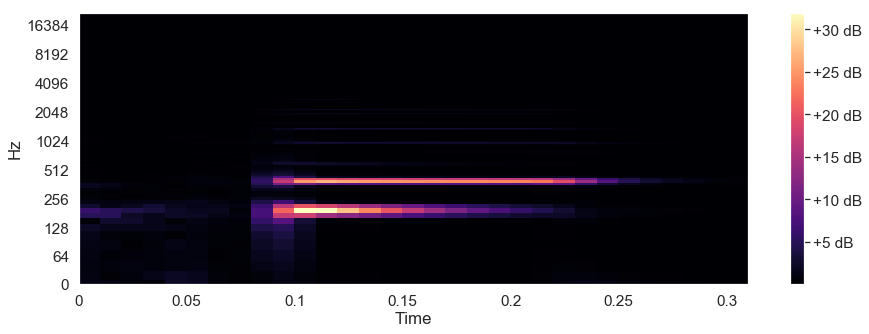

In [794]:
clip_num = 3
print (y_all[file][clip_num])
plt.figure(figsize=(15, 5))
librosa.display.specshow(abs(X_NYU_STFT[clip_num]), sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
ipd.Audio(all_clips_dataset[file][clip_num], rate = sr)

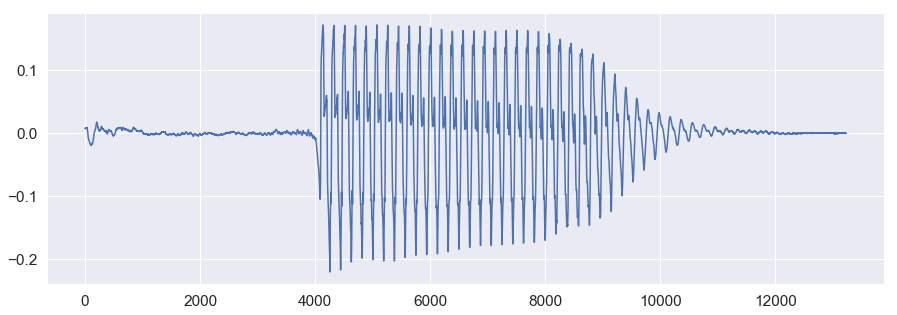

In [792]:
plt.plot(all_clips_dataset[file][clip_num])

In [600]:
file = 0
annotation_track = jams.load(solo_files_paths[file])
onset_track = visualize_jams_onset_asList(annotation_track, visualize = False)
librosa_onsets_track = librosa_onsets(all_audio_files[file], SAMPLE_RATE, onset_track)
all_clips = clip_from_onset(librosa_onsets_track, SAMPLE_RATE, all_audio_files[file])

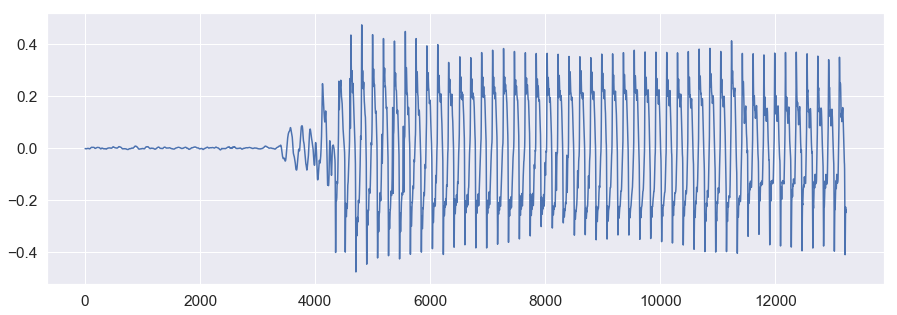

In [788]:
# Plotting training dataset
clip = all_clips_clean[105]
plt.plot(clip)
ipd.Audio(clip, rate = sr)

In [573]:
print (onset_track)
print (librosa_onsets_track)

[[ 0.22642268  3.        ]
 [ 1.84118458  1.        ]
 [ 2.0348127   2.        ]
 [ 2.35245442  3.        ]
 [ 3.98816871  1.        ]
 [ 4.1587356   2.        ]
 [ 4.48447256  2.        ]
 [ 4.65549297  2.        ]
 [ 4.71392834  3.        ]
 [ 6.18488073  3.        ]
 [ 6.28059501  3.        ]
 [ 6.39517551  3.        ]
 [ 6.54458594  3.        ]
 [ 8.44501678  3.        ]
 [ 8.57338413  3.        ]
 [ 8.89347483  3.        ]
 [10.46547029  3.        ]
 [10.71971066  3.        ]
 [11.07674014  3.        ]
 [12.64420045  3.        ]
 [12.77764717  3.        ]
 [12.93138866  3.        ]
 [13.03506213  3.        ]
 [13.56753379  3.        ]
 [14.15533424  3.        ]
 [14.72973333  3.        ]
 [15.05111655  4.        ]
 [16.20347483  4.        ]
 [16.56587846  4.        ]
 [16.81152472  4.        ]
 [16.94562902  3.        ]
 [17.21079909  4.        ]
 [17.69336145  4.        ]
 [18.30998277  4.        ]
 [18.46011882  4.        ]
 [18.55728435  4.        ]
 [18.854722    3.        ]
 

In [575]:
solo_files_paths[0]

'GuitarSet/annotation/04_Jazz2-110-Bb_solo.jams'

In [599]:
librosa_onsets_track[1]

array([3.98222222, 1.        ])

In [637]:
snippets = []
samples_all = []
strings_all = []
for clip in np.arange(len(librosa_onsets_track)):
    onset_sample = int(librosa_onsets_track[clip][0] * sr)
    onset_string = int(librosa_onsets_track[clip][1])
    test = all_audio_files[file][string][onset_sample - ta: onset_sample + tb]
    snippets.append(test)
    samples_all.append(onset_sample/float(sr))
    strings_all.append(onset_string)

32.82140589569161
5


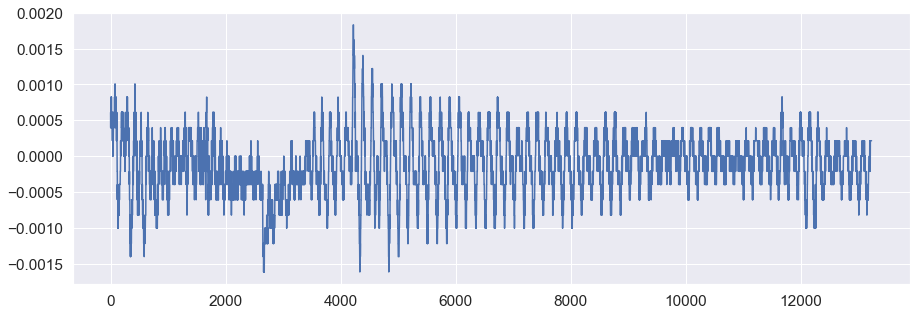

In [634]:
print (onset_sample/float(sr))
print (onset_string)
x = snippets[40]
plt.plot(x)
ipd.Audio(x, rate = sr)

In [639]:
print (samples_all)
print (strings_all)

[1.8459863945578232, 3.982222222222222, 2.0317460317460316, 4.156371882086168, 4.481451247165533, 4.655600907029479, 20.503219954648525, 21.61777777777778, 21.873197278911565, 21.873197278911565, 22.163424036281178, 23.23156462585034, 24.322902494331064, 24.88018140589569, 27.794285714285714, 28.328344671201815, 0.22058956916099773, 4.713650793650793, 6.188117913832199, 6.280997732426304, 6.397097505668934, 6.548027210884354, 8.440453514739229, 8.568163265306122, 8.893219954648526, 10.460589569160998, 10.716009070294785, 11.075918367346938, 12.64326530612245, 12.782585034013605, 12.933514739229025, 13.038004535147392, 13.56045351473923, 14.152562358276644, 14.733061224489797, 16.938956916099773, 18.854603174603174, 19.423492063492063, 20.01560090702948, 20.17814058956916, 22.38403628117914, 22.50013605442177, 22.66267573696145, 22.88326530612245, 22.88326530612245, 25.437460317460317, 25.994739229024944, 27.051247165532878, 27.109297052154194, 27.260226757369615, 28.665034013605442, 28

In [594]:
ipd.Audio(snippet, rate = sr)

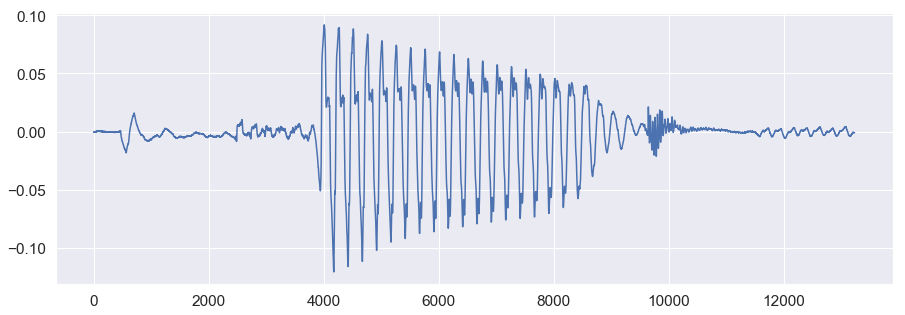

In [589]:
plt.plot(snippet)